# Лабораторная работа Классификация *kNN*

Yelp — веб-сайт для поиска на местном рынке услуг, например ресторанов или парикмахерских, с возможностью добавлять и просматривать рейтинги и обзоры этих услуг. Для популярных бизнесов имеются сотни обзоров. Для обозревателей на сайте предусмотрены элементы социальной сети.

---

yelp_academic_dataset_business.json
| Признак      | Описание                                  | Тип     |
| ------------ | ----------------------------------------- | ------- |
| business_id  | Уникальный идентификатор компании         | object  |
| name         | Название компании                         | object  |
| address      | Адрес компании                            | object  |
| city         | Город, в котором находится компания       | object  |
| state        | Штат, в котором находится компания        | object  |
| postal_code  | Почтовый индекс                           | object  |
| latitude     | Широта                                    | float64 |
| longitude    | Долгота                                   | float64 |
| stars        | Рейтинг компании (от 1 до 5)              | float64 |
| review_count | Количество отзывов                        | int64   |
| is_open      | Статус работы компании (1 — да, 0 — нет)  | int64   |
| attributes   | Атрибуты компании (например, доступность) | object  |
| categories   | Категории услуг компании                  | object  |
| hours        | Часы работы компании                      | object  |

yelp_academic_dataset_review.json
| Признак     | Описание                              | Тип        |
| ----------- | ------------------------------------- | ---------- |
| review_id   | Уникальный идентификатор отзыва       | object     |
| user_id     | Уникальный идентификатор пользователя | object     |
| business_id | Уникальный идентификатор компании     | object     |
| stars       | Рейтинг отзыва (от 1 до 5)            | int64      |
| useful      | Количество полезных голосов           | int64      |
| funny       | Количество голосов "смешно"           | int64      |
| cool        | Количество голосов "классно"          | int64      |
| text        | Текст отзыва                          | object     |
| date        | Дата написания отзыва                 | datetime64 |

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


In [13]:
business = pd.read_json(r'../lab1/yelp_academic_dataset_business.json', lines=True)

## Бинарная классификация (is_open)


### Предобработка данных

In [14]:
business_filtered = business[(business['stars'] <= 2) | (business['stars'] >= 4)].copy()
business_filtered['target'] = np.where(business_filtered['stars'] >= 4, 1, 0)

# Удаление ненужных признаков
cols_to_drop = ['business_id', 'name', 'address', 'postal_code', 'attributes', 'categories', 'hours', 'city', 'stars']
business_clean = business_filtered.drop(columns=cols_to_drop).dropna(subset=['target'])

# One-Hot Encoding для 'state'
business_encoded = pd.get_dummies(business_clean, columns=['state'])

# Разделение на X и y
X = business_encoded.drop(columns=['target'])
y = business_encoded['target']

# Проверка баланса классов
print("Распределение классов:\n", y.value_counts())

# Разделение на train/test (со стратификацией)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Распределение классов:
 target
1    74613
0    16445
Name: count, dtype: int64


### Обучение без нормализации

In [15]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Метрики без нормализации:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Метрики без нормализации:
Accuracy: 0.7917307269931912
Precision: 0.8269298554811421
Recall: 0.9432419754741004
F1: 0.8812646736578494
              precision    recall  f1-score   support

           0       0.29      0.10      0.15      3289
           1       0.83      0.94      0.88     14923

    accuracy                           0.79     18212
   macro avg       0.56      0.52      0.52     18212
weighted avg       0.73      0.79      0.75     18212



### Обучение с нормализацией

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_scaled = KNeighborsClassifier(n_neighbors=5)
knn_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = knn_scaled.predict(X_test_scaled)

print("\nМетрики с нормализацией:")
print("Accuracy:", accuracy_score(y_test, y_pred_scaled))
print("Precision:", precision_score(y_test, y_pred_scaled))
print("Recall:", recall_score(y_test, y_pred_scaled))
print("F1:", f1_score(y_test, y_pred_scaled))
print(classification_report(y_test, y_pred_scaled))


Метрики с нормализацией:
Accuracy: 0.7909620030748957
Precision: 0.8283705541770058
Recall: 0.9395563894659251
F1: 0.8804672046218092
              precision    recall  f1-score   support

           0       0.30      0.12      0.17      3289
           1       0.83      0.94      0.88     14923

    accuracy                           0.79     18212
   macro avg       0.56      0.53      0.52     18212
weighted avg       0.73      0.79      0.75     18212



### Отбор признаков

In [17]:
# Вычисление корреляционной матрицы
corr_matrix = pd.DataFrame(X_train_scaled, columns=X.columns).corr()
np.fill_diagonal(corr_matrix.values, 0)

# Фильтрация признаков (T_corr = 0.3)
feature_importance = corr_matrix.abs().sum(axis=1)
selected_features = feature_importance[feature_importance > feature_importance.quantile(0.7)].index

# Обучение с отобранными признаками
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

scaler_selected = StandardScaler()
X_train_selected_scaled = scaler_selected.fit_transform(X_train_selected)
X_test_selected_scaled = scaler_selected.transform(X_test_selected)

knn_selected = KNeighborsClassifier(n_neighbors=5)
knn_selected.fit(X_train_selected_scaled, y_train)
y_pred_selected = knn_selected.predict(X_test_selected_scaled)

print("\nМетрики после отбора признаков:")
print("Accuracy:", accuracy_score(y_test, y_pred_selected))
print("Precision:", precision_score(y_test, y_pred_selected))
print("Recall:", recall_score(y_test, y_pred_selected))
print("F1:", f1_score(y_test, y_pred_selected))
print(classification_report(y_test, y_pred_selected))


Метрики после отбора признаков:
Accuracy: 0.8051833955633648
Precision: 0.841940720254915
Recall: 0.9384172083361254
F1: 0.8875649638737483
              precision    recall  f1-score   support

           0       0.42      0.20      0.27      3289
           1       0.84      0.94      0.89     14923

    accuracy                           0.81     18212
   macro avg       0.63      0.57      0.58     18212
weighted avg       0.77      0.81      0.78     18212



### Подбор гиперпараметра k

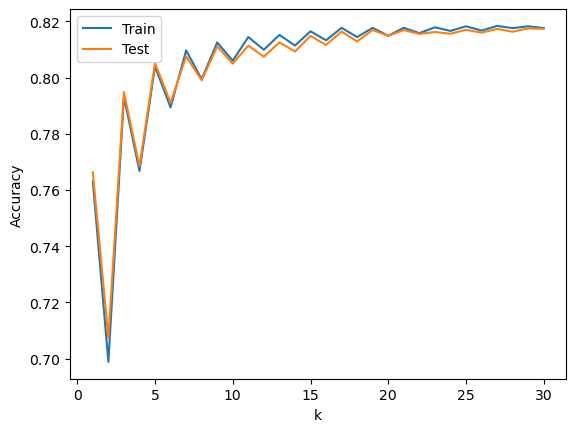

In [18]:
import matplotlib.pyplot as plt

k_values = range(1, 31)
train_acc = []
test_acc = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_selected_scaled, y_train, cv=5, scoring='accuracy')
    train_acc.append(np.mean(scores))
    knn.fit(X_train_selected_scaled, y_train)
    test_acc.append(knn.score(X_test_selected_scaled, y_test))

plt.plot(k_values, train_acc, label='Train')
plt.plot(k_values, test_acc, label='Test')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Многоклассовая классификация (stars в отзывах)


### Предобработка данных

In [19]:
reviews = pd.read_json(r'../lab1/yelp_academic_dataset_review.json', lines=True)


In [20]:
merged = reviews.merge(business, on='business_id', how='left')

# Удаление ненужных признаков
cols_to_drop = ['review_id', 'user_id', 'text', 'date', 'business_id', 'name', 'address', 
                'postal_code', 'attributes', 'categories', 'hours', 'city', 'is_open']
merged_clean = merged.drop(columns=cols_to_drop).dropna(subset=['stars_x'])

# One-Hot Encoding для 'state'
merged_encoded = pd.get_dummies(merged_clean, columns=['state'])

# Целевая переменная: звездный рейтинг отзыва (1-5)
X = merged_encoded.drop(columns=['stars_x'])
y = merged_encoded['stars_x'].astype(int)

# Проверка распределения классов
print("Распределение звезд:\n", y.value_counts())


Распределение звезд:
 stars_x
5    3231627
4    1452918
1    1069561
3     691934
2     544240
Name: count, dtype: int64


### Обучение с нормализацией

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

print("\nМетрики многоклассовой классификации:")
print(classification_report(y_test, y_pred))


Метрики многоклассовой классификации:
              precision    recall  f1-score   support

           1       0.42      0.52      0.47    213912
           2       0.15      0.10      0.12    108848
           3       0.16      0.11      0.13    138387
           4       0.29      0.26      0.28    290584
           5       0.60      0.66      0.63    646325

    accuracy                           0.46   1398056
   macro avg       0.32      0.33      0.32   1398056
weighted avg       0.43      0.46      0.44   1398056



### Отбор признаков

In [22]:
corr_matrix = pd.DataFrame(X_train_scaled, columns=X.columns).corr()
np.fill_diagonal(corr_matrix.values, 0)

T_corr = 0.2
feature_importance = corr_matrix.abs().sum(axis=1)
selected_features = feature_importance[feature_importance > feature_importance.quantile(0.7)].index

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

scaler_selected = StandardScaler()
X_train_selected_scaled = scaler_selected.fit_transform(X_train_selected)
X_test_selected_scaled = scaler_selected.transform(X_test_selected)

knn_selected = KNeighborsClassifier(n_neighbors=5)
knn_selected.fit(X_train_selected_scaled, y_train)
y_pred_selected = knn_selected.predict(X_test_selected_scaled)

print("\nМетрики после отбора признаков:")
print(classification_report(y_test, y_pred_selected))


Метрики после отбора признаков:
              precision    recall  f1-score   support

           1       0.39      0.46      0.42    213912
           2       0.14      0.09      0.11    108848
           3       0.15      0.11      0.13    138387
           4       0.28      0.26      0.27    290584
           5       0.58      0.63      0.60    646325

    accuracy                           0.43   1398056
   macro avg       0.31      0.31      0.31   1398056
weighted avg       0.41      0.43      0.42   1398056



### Confusion Matrix

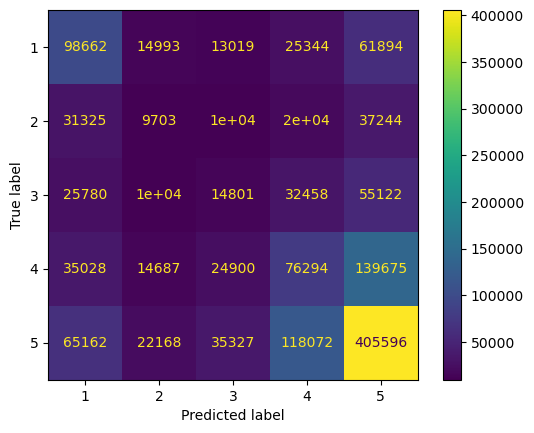

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_selected)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_selected.classes_)
disp.plot()
plt.show()